# FinBERT
## Imports

In [1]:
COLAB = False
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = "data/"
  %cd drive/MyDrive/ml4fin
  !pip install pandas numpy torch transformers tqdm --quiet
else:
  data_path = "../../data/"

In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
tqdm.pandas()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/jdidio/kDrive/EPFL/Master - DS/MA4/ML4Fin/ml4fin/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and processing

In [8]:
raw_dataset = pd.read_csv(data_path + "processed/clean_df.csv")
raw_dataset

,date,exchange,q,ticker,transcript,year,time,before,after,change_during_news,change_day_after,change_week_after,change_month_after,processed_transcript
0,2020-08-27 21:00:00,NASDAQ,Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020,21:00:00,False,True,0.012627,0.036753,0.027565,-0.088602,"['prepared', 'remarks', 'operator', 'good', 'd..."
1,2020-07-30 16:30:00,NYSE,Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020,16:30:00,False,True,0.048934,0.056351,0.069746,0.065570,"['prepared', 'remarks', 'operator', 'thank', '..."
2,2019-10-23 17:00:00,NASDAQ,Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019,17:00:00,False,True,0.082640,0.052090,0.096415,0.051614,"['prepared', 'remarks', 'operator', 'good', 'd..."
3,2019-08-07 08:30:00,NASDAQ,Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019,08:30:00,True,False,-0.069474,0.164404,0.188537,0.141780,"['prepared', 'remarks', 'operator', 'greetings..."
4,2020-11-04 17:00:00,NYSE,Q3,GDOT,"Prepared Remarks:\nOperator\nGood afternoon, a...",2020,17:00:00,False,True,0.030364,-0.045350,-0.023469,-0.049409,"['prepared', 'remarks', 'operator', 'good', 'a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11200,2021-08-11 08:00:00,NYSE,Q1,HAE,Prepared Remarks:\nOperator\nGood day and than...,2021,08:00:00,True,False,0.013331,0.058773,0.016402,0.076542,"['prepared', 'remarks', 'operator', 'good', 'd..."
11201,2021-08-12 16:30:00,NASDAQ,Q3,AVXL,Prepared Remarks:\nOperator\nGood afternoon. M...,2021,16:30:00,False,True,-0.007784,0.022489,-0.047071,-0.006276,"['prepared', 'remarks', 'operator', 'good', 'a..."
11202,2022-08-24 17:00:00,NASDAQ,Q2,NVDA,Prepared Remarks:\nOperator\nGood afternoon. M...,2022,17:00:00,False,True,-0.021949,0.063465,-0.156436,-0.262645,"['prepared', 'remarks', 'operator', 'good', 'a..."
11203,2022-08-04 17:00:00,NASDAQ,Q2,DH,"Prepared Remarks:\nOperator\nGood day, and wel...",2022,17:00:00,False,True,-0.216843,0.066826,0.009578,-0.150196,"['prepared', 'remarks', 'operator', 'good', 'd..."


In [9]:
def get_qa(text):
    pattern = ["Questions and Answers", "Questions & Answers"]
    if pattern[0] in text:
        return text[text.index(pattern[0]):]
    elif pattern[1] in text:
        return text[text.index(pattern[1]):]
    else:
        return None

raw_dataset["transcript"] = raw_dataset["transcript"].progress_apply(get_qa)
raw_dataset.dropna(inplace=True)
raw_dataset

100%|██████████| 11205/11205 [00:00<00:00, 44078.81it/s]


,date,exchange,q,ticker,transcript,year,time,before,after,change_during_news,change_day_after,change_week_after,change_month_after,processed_transcript
0,2020-08-27 21:00:00,NASDAQ,Q2,BILI,"Questions and Answers:\nOperator\nThank you, s...",2020,21:00:00,False,True,0.012627,0.036753,0.027565,-0.088602,"['prepared', 'remarks', 'operator', 'good', 'd..."
1,2020-07-30 16:30:00,NYSE,Q3,GFF,Questions and Answers:\nOperator\nCertainly. [...,2020,16:30:00,False,True,0.048934,0.056351,0.069746,0.065570,"['prepared', 'remarks', 'operator', 'thank', '..."
2,2019-10-23 17:00:00,NASDAQ,Q1,LRCX,Questions and Answers:\nOperator\nThank you. [...,2019,17:00:00,False,True,0.082640,0.052090,0.096415,0.051614,"['prepared', 'remarks', 'operator', 'good', 'd..."
3,2019-08-07 08:30:00,NASDAQ,Q2,CSTE,Questions and Answers:\nOperator\nThank you. A...,2019,08:30:00,True,False,-0.069474,0.164404,0.188537,0.141780,"['prepared', 'remarks', 'operator', 'greetings..."
4,2020-11-04 17:00:00,NYSE,Q3,GDOT,Questions and Answers:\nOperator\n[Operator In...,2020,17:00:00,False,True,0.030364,-0.045350,-0.023469,-0.049409,"['prepared', 'remarks', 'operator', 'good', 'a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11200,2021-08-11 08:00:00,NYSE,Q1,HAE,Questions and Answers:\nOperator\n[Operator In...,2021,08:00:00,True,False,0.013331,0.058773,0.016402,0.076542,"['prepared', 'remarks', 'operator', 'good', 'd..."
11201,2021-08-12 16:30:00,NASDAQ,Q3,AVXL,Questions & Answers:\nOperator\n[Operator inst...,2021,16:30:00,False,True,-0.007784,0.022489,-0.047071,-0.006276,"['prepared', 'remarks', 'operator', 'good', 'a..."
11202,2022-08-24 17:00:00,NASDAQ,Q2,NVDA,Questions & Answers:\nOperator\n[Operator inst...,2022,17:00:00,False,True,-0.021949,0.063465,-0.156436,-0.262645,"['prepared', 'remarks', 'operator', 'good', 'a..."
11203,2022-08-04 17:00:00,NASDAQ,Q2,DH,Questions & Answers:\nOperator\n[Operator inst...,2022,17:00:00,False,True,-0.216843,0.066826,0.009578,-0.150196,"['prepared', 'remarks', 'operator', 'good', 'd..."


## Sentiment inference - No summarization

In [10]:
if COLAB:

  text_data = raw_dataset['transcript'].tolist()
  tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
  model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
  logits = []
  batch_size = 300
  model.eval()
  with torch.no_grad():
      for i in tqdm(range(0, len(text_data), batch_size)):
          inputs = tokenizer(text_data[i:i+batch_size], return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
          logits.append(model(**inputs).logits)
  probs = torch.cat(logits).softmax(-1)
  torch.save(probs, "data/processed/finbert_probs.pt")
else:
  probs = torch.load(data_path + "processed/finbert_probs.pt", map_location=torch.device(device))

## Results - No summarization

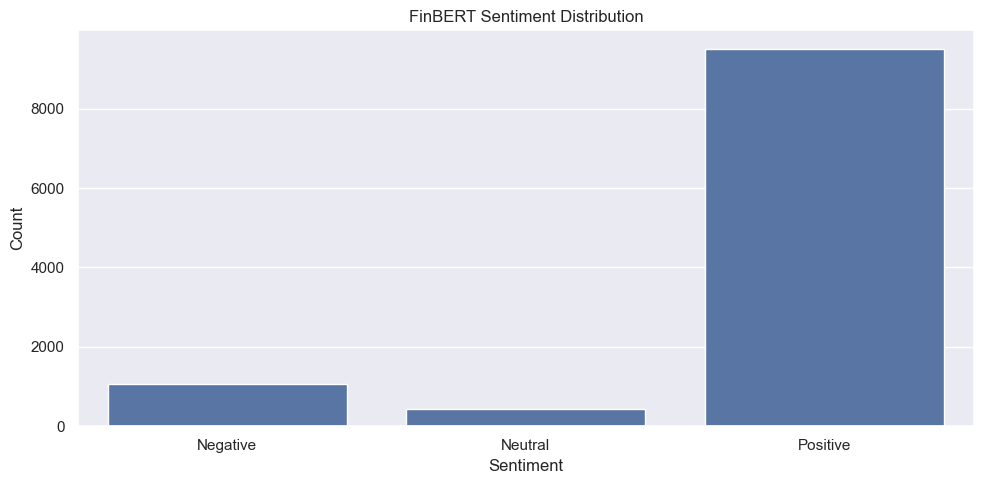

In [11]:
pred = pd.DataFrame()
pred['finbert_pred'] = probs.argmax(-1).cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(pred, x="finbert_pred", ax=ax)
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Negative", "Neutral", "Positive"])
ax.set_title("FinBERT Sentiment Distribution")
plt.tight_layout()
plt.show()

In [24]:
pred = pd.DataFrame(index=raw_dataset.index, columns=["positive", "negative", "neutral"])

In [27]:
pred["positive"] = probs[:, 2].cpu().numpy()
pred["negative"] = probs[:, 0].cpu().numpy()
pred["neutral"] = probs[:, 1].cpu().numpy()
pred.to_pickle(data_path + "processed/finbert_probs_only_qa.pkl")

## Results 

In [3]:
predictions = pd.read_pickle(data_path + "processed/finbert_probs_only_qa.pkl")
predictions['prediction'] = predictions.idxmax(axis=1)

In [4]:
predictions.prediction.value_counts()

prediction
positive    8740
negative     995
neutral      400
Name: count, dtype: int64

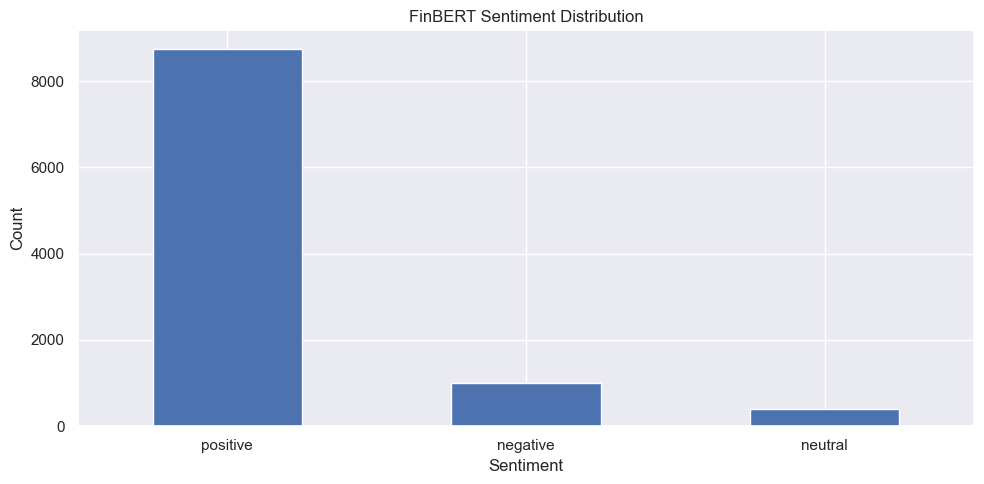

In [8]:
predictions.prediction.value_counts().plot(kind='bar', figsize=(10, 5))
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("FinBERT Sentiment Distribution")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()